# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import datetime
import time

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '33241'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1672419899801'),
 ('spark.driver.host', 'b79755e2b05a'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# load data
df = spark.read.json("mini_sparkify_event_data.json")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.count()

286500

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

#### Check records without userids or sessionids

In [8]:
# drop rows with missing values in userid and/or sessionid
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df.count()

286500


Observe that userId and sessionId have 286500 non-null that is same as the number of rows, means there's no null in these two columns.

In [9]:
# Because userId is a string column, so carefully check empty string in this column
df = df.filter(df['userId'] != '')
df.count()

278154

Now the dataframe is cleaned missing userId and sessionId.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# Check Cancellation Confirmation page
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



From above, we can know that there're 52 users confirm that they cancel the subscription.

Query all users that enter to Cancellation Confirmation page, and save it to a dataframe. Add new column Churn as a flag, with value 1.

In [11]:
# mark the flag where Cancellation Confirmation page is reached = 1 otherwise = 0
is_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [12]:
# creating churn column
df = df.withColumn('churn', is_churn('page'))

In [13]:
# sort by ts so that we can add values into churn column
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

In [14]:
# replace churn column with real values
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [15]:
# show users count churned vs. stayed
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



#### Stayed Users vs Churned Users Number

Text(0.5,1,'Number of Churned Users and Stayed Users')

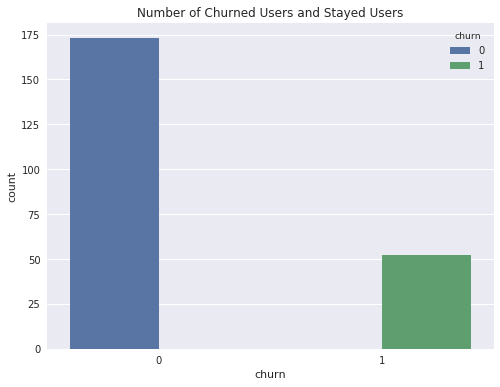

In [16]:
# plot the number of users that churned
plt.figure(figsize=[8, 6])
sns.barplot(data = df_churn.toPandas(), x = 'churn', y = 'count', hue = 'churn')
plt.title('Number of Churned Users and Stayed Users')

In [17]:
# Churn rate
churn_rate = 52/225*100
churn_rate

23.11111111111111

#### Stayed Users vs Churned Users Page Visited

In [18]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page', 'churn').count()
df_page.show()

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0| 1244|
|         Thumbs Down|    1|  496|
|           Thumbs Up|    1| 1859|
|     Add to Playlist|    1| 1038|
|               Error|    1|   32|
|               About|    1|   56|
|         Thumbs Down|    0| 2050|
|         Roll Advert|    1|  967|
|                Home|    0| 8410|
|Cancellation Conf...|    1|   52|
|               Error|    0|  220|
|              Cancel|    1|   52|
|            Settings|    1|  270|
|          Add Friend|    1|  636|
|             Upgrade|    0|  387|
|           Downgrade|    1|  337|
|              Logout|    1|  553|
|    Submit Downgrade|    1|    9|
|       Save Settings|    0|  252|
|           Thumbs Up|    0|10692|
+--------------------+-----+-----+
only showing top 20 rows



In [19]:
# calculate total actions of churned users and stayed
df_page = df_page.toPandas()
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

In [20]:
# calculate the rate of pages visited by churned users vs. stayed users
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])) 
df_page.head()

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713


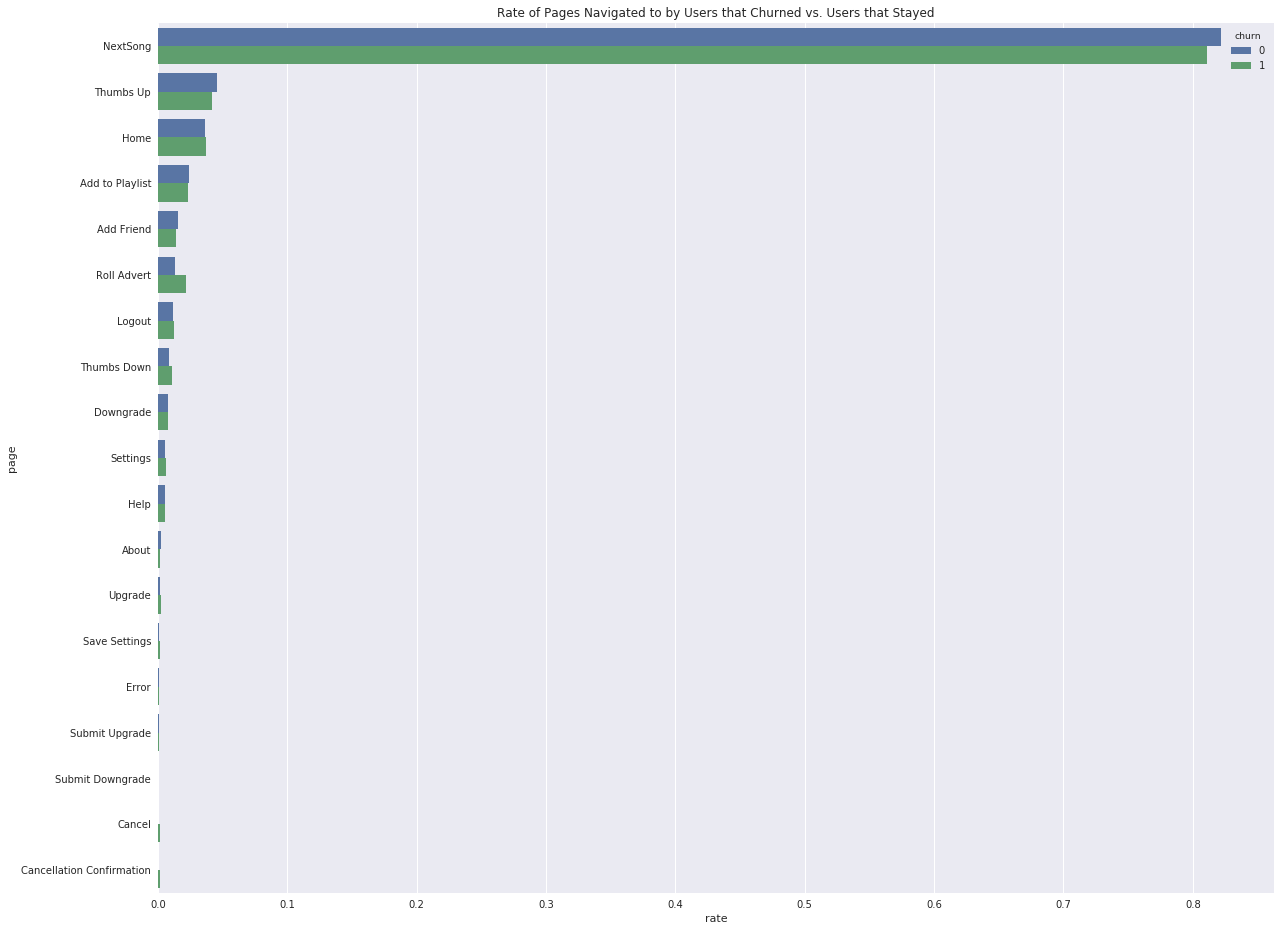

In [21]:
# plot the page visting count by churn
df_page = df_page.sort_values(['count'], ascending=False)
plt.figure(figsize=[20,16])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed');

From the above chart, we can see that the most popular action for both users that stayed and those that churned was to skip to the next song. We can also see that churned users rolled advert more near 100% than stayed users, and more thumbs down as well. Stayed users performed more thumbs up actions, added friends and also added songs to playlist.

##### Stayed Users vs. Churned Users By Gender

In [22]:
# create a dataframe grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



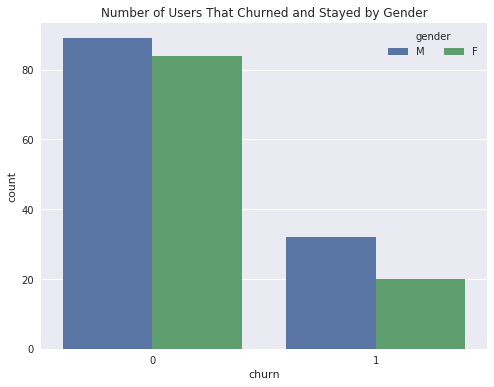

In [23]:
# Plot bar chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender.toPandas().sort_values('count', ascending = False), x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users That Churned and Stayed by Gender");

From the above chart, we can see that there're more male users churned than female users.

##### Stayed Users vs. Churned Users by Level

In [24]:
# create a dataframe grouped by churn and level
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level', 'churn').count()
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



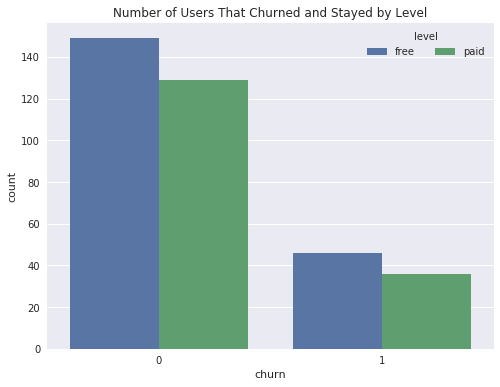

In [25]:
# Plot bar chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level.toPandas().sort_values('count', ascending = False), x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of Users That Churned and Stayed by Level");

We can see from the above chart that more users who used the service for free were churned more than those who paid for the app but not much.

##### Songs Per Session for Churned Users vs. Stayed Users

In [26]:
# create a dataframe grouped by churn and session
df_song = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count().groupby('churn').mean()
df_song.show()

+-----+------------------+----------+-----------------+
|churn|    avg(sessionId)|avg(churn)|       avg(count)|
+-----+------------------+----------+-----------------+
|    0|1194.0608568646544|       0.0| 93.3369036027264|
|    1| 556.3048245614035|       1.0|79.81140350877193|
+-----+------------------+----------+-----------------+



Text(0,0.5,'Average Number of Songs Played Per Session')

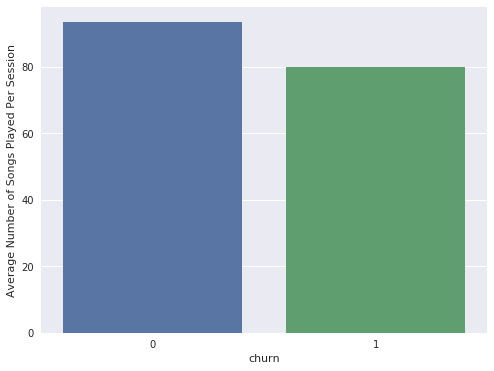

In [27]:
# Plot bar chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_song.toPandas(), x = 'churn', y='avg(count)')
plt.ylabel('Average Number of Songs Played Per Session')

From the chart above, we can see that the churned users listened fewer songs than stayed users.

##### Number of Different Artists Listened to between Churned Users vs. Stayed Users

In [28]:
# create a dataframe grouped by churn and artist
df_artist = df.select(['churn', 'artist', 'userId']).dropDuplicates().groupBy('userId', 'churn').count().groupby('churn').mean()
df_artist.show()

+-----+----------+-----------------+
|churn|avg(churn)|       avg(count)|
+-----+----------+-----------------+
|    0|       0.0|750.7803468208092|
|    1|       1.0|519.6923076923077|
+-----+----------+-----------------+



Text(0,0.5,'The number of different artists listened by Churned Users vs. Stayed Users')

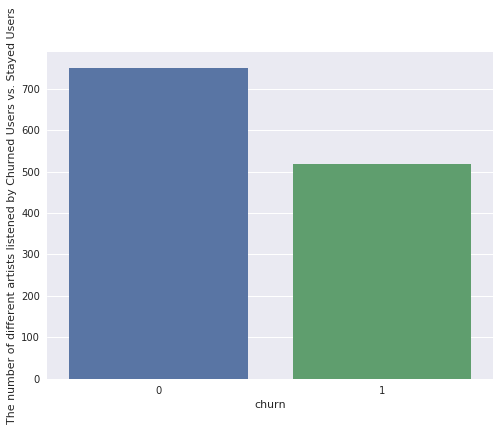

In [29]:
# Plot bar chart
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_artist.toPandas(), x = 'churn', y='avg(count)')
plt.ylabel("The number of different artists listened by Churned Users vs. Stayed Users")

From the above barchart, we can see that stayed users listened to a variety of artists more than users who churn.

#### Days Since Registration for Sparkify

In [30]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [31]:
# order the df by last timestamp
w = Window.partitionBy('userId').orderBy(desc('ts'))

In [32]:
# ranking by adding rank column
df_days = df_days.withColumn('rank', dense_rank().over(w))

In [33]:
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [34]:
# get only rows at rank = 1
df_days = df_days.filter(df_days.rank == 1).drop(df_days.rank)

In [35]:
# calculate the number of days since the registration
df_days = df_days.withColumn('delta', (df_days['ts']) - (df_days['registration']))

In [36]:
# convert delta to days
df_days = df_days.withColumn('days',(df_days['delta']/1000/3600/24))

In [37]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn|      delta|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

Text(0.5,1,'Number of Stayed Users and Churned Users by Days Since Registration')

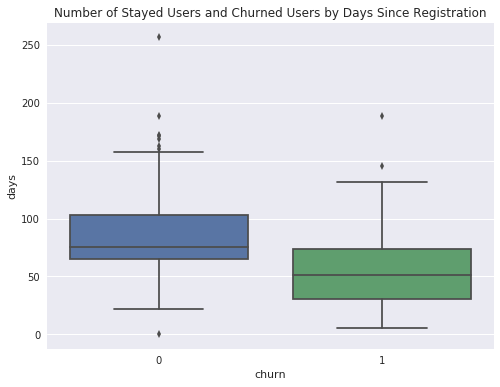

In [38]:
# plot a boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df_days.toPandas(), x = 'churn', y ='days')
plt.title('Number of Stayed Users and Churned Users by Days Since Registration')

From the boxplot, we can see that the more longer registration the more chance that users stay.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Build out the features that find promising to train your model on:
1. Categorical:
    - Gender
    - Level
2. Numerical:
    - Number of songs per session
    - Number of roll advert actions
    - Number of thumb down actions
    - Number of thumbs up actions
    - Number of songs added to playlist
    - Number of different artists listened to on Sparkify
    - Number of days since registering

### Gender

In [39]:
gender = df.select(['userId', 'gender']).dropDuplicates()

In [40]:
# replace Female with 1 and M with 0
gender = gender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))
gender.show()

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



### Level

In [41]:
sorted_df = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

In [42]:
# ranking userId 
w = Window.partitionBy('userId').orderBy(desc('ts'))

In [43]:
sorted_df = sorted_df.withColumn('rank', dense_rank().over(w))
sorted_df.show()

+------+-----+-------------+----+
|userId|level|           ts|rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [44]:
level = sorted_df.filter(sorted_df.rank == 1).drop(sorted_df.rank).drop('ts')

In [45]:
level = level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))
level.show()

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



### Average Number of Songs per Session

In [46]:
song = df.filter(df.page == 'NextSong').groupBy('userId','sessionId').count()[['userId', 'count']].groupBy('userId').mean()
song.show()

+------+------------------+
|userId|        avg(count)|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [47]:
# rename column
song = song.withColumnRenamed("avg(count)", "avg_song")
song.show()

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



### Number of roll advert actions

In [48]:
roll_ad = df.select(['userId', 'page'])

In [49]:
# fill 1 if that cell = 'Roll Advert' otherwise 0
is_roll_ad = udf(lambda x: 1 if x == 'Roll Advert' else 0, IntegerType())

In [50]:
# replace page column with num 1 and 0
roll_ad = roll_ad.withColumn('is_roll_ad', is_roll_ad('page'))

In [51]:
roll_ad = roll_ad.groupby('userId').sum('is_roll_ad')
roll_ad.show()

+------+---------------+
|userId|sum(is_roll_ad)|
+------+---------------+
|100010|             52|
|200002|              7|
|   125|              1|
|    51|              0|
|   124|              4|
|     7|             16|
|    54|             47|
|    15|              1|
|   155|              8|
|   132|              2|
|   154|             10|
|100014|              2|
|   101|              8|
|    11|             39|
|   138|             17|
|300017|             11|
|    29|             22|
|    69|              3|
|100021|             30|
|    42|             10|
+------+---------------+
only showing top 20 rows



In [52]:
# rename column
roll_ad = roll_ad.withColumnRenamed("sum(is_roll_ad)", "roll_ad")
roll_ad.show()

+------+-------+
|userId|roll_ad|
+------+-------+
|100010|     52|
|200002|      7|
|   125|      1|
|    51|      0|
|   124|      4|
|     7|     16|
|    54|     47|
|    15|      1|
|   155|      8|
|   132|      2|
|   154|     10|
|100014|      2|
|   101|      8|
|    11|     39|
|   138|     17|
|300017|     11|
|    29|     22|
|    69|      3|
|100021|     30|
|    42|     10|
+------+-------+
only showing top 20 rows



### Number of thumb down actions

In [53]:
thumbdown = df.select(['userId', 'page'])

In [54]:
# fill 1 if that cell = 'Thumbs Down' otherwise 0
is_thumbdown = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())

In [55]:
# replace page column with num 1 and 0
thumbdown = thumbdown.withColumn('is_thumbdown', is_thumbdown('page'))

In [56]:
thumbdown = thumbdown.groupby('userId').sum('is_thumbdown')
thumbdown.show()

+------+-----------------+
|userId|sum(is_thumbdown)|
+------+-----------------+
|100010|                5|
|200002|                6|
|   125|                0|
|    51|               21|
|   124|               41|
|     7|                1|
|    54|               29|
|    15|               14|
|   155|                3|
|   132|               17|
|   154|                0|
|100014|                3|
|   101|               16|
|    11|                9|
|   138|               24|
|300017|               28|
|    29|               22|
|    69|                9|
|100021|                5|
|    42|               25|
+------+-----------------+
only showing top 20 rows



In [57]:
# rename column
thumbdown = thumbdown.withColumnRenamed("sum(is_thumbdown)", "thumbs_down")
thumbdown.show()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
|   125|          0|
|    51|         21|
|   124|         41|
|     7|          1|
|    54|         29|
|    15|         14|
|   155|          3|
|   132|         17|
|   154|          0|
|100014|          3|
|   101|         16|
|    11|          9|
|   138|         24|
|300017|         28|
|    29|         22|
|    69|          9|
|100021|          5|
|    42|         25|
+------+-----------+
only showing top 20 rows



### Number of thumbs up actions

In [58]:
thumbup = df.select(['userId', 'page'])

In [59]:
# fill 1 if that cell = 'Thumbs Up' otherwise 0
is_thumbup = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())

In [60]:
# replace page column with num 1 and 0
thumbup = thumbup.withColumn('is_thumbup', is_thumbup('page'))

In [61]:
thumbup = thumbup.groupby('userId').sum('is_thumbup')
thumbup.show()

+------+---------------+
|userId|sum(is_thumbup)|
+------+---------------+
|100010|             17|
|200002|             21|
|   125|              0|
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
|   155|             58|
|   132|             96|
|   154|             11|
|100014|             17|
|   101|             86|
|    11|             40|
|   138|             95|
|300017|            303|
|    29|            154|
|    69|             72|
|100021|             11|
|    42|            166|
+------+---------------+
only showing top 20 rows



In [62]:
# rename column
thumbup = thumbup.withColumnRenamed("sum(is_thumbup)", "thumbs_up")
thumbup.show()

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
|     7|        7|
|    54|      163|
|    15|       81|
|   155|       58|
|   132|       96|
|   154|       11|
|100014|       17|
|   101|       86|
|    11|       40|
|   138|       95|
|300017|      303|
|    29|      154|
|    69|       72|
|100021|       11|
|    42|      166|
+------+---------+
only showing top 20 rows



### Number of songs added to playlist

In [63]:
playlist = df.select(['userId', 'page'])

In [64]:
# fill 1 if that cell = 'Add to Playlist' otherwise 0
add_playlist = udf(lambda x: 1 if x == 'Add to Playlist' else 0, IntegerType())

In [65]:
# replace page column with num 1 and 0
playlist = playlist.withColumn('is_add_playlist', add_playlist('page'))

In [66]:
playlist = playlist.groupby('userId').sum('is_add_playlist')
playlist.show()

+------+--------------------+
|userId|sum(is_add_playlist)|
+------+--------------------+
|100010|                   7|
|200002|                   8|
|   125|                   0|
|    51|                  52|
|   124|                 118|
|     7|                   5|
|    54|                  72|
|    15|                  59|
|   155|                  24|
|   132|                  38|
|   154|                   1|
|100014|                   7|
|   101|                  61|
|    11|                  20|
|   138|                  67|
|300017|                 113|
|    29|                  89|
|    69|                  33|
|100021|                   7|
|    42|                 104|
+------+--------------------+
only showing top 20 rows



In [67]:
# rename column
playlist = playlist.withColumnRenamed("sum(is_add_playlist)", "playlist")
playlist.show()

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
|   125|       0|
|    51|      52|
|   124|     118|
|     7|       5|
|    54|      72|
|    15|      59|
|   155|      24|
|   132|      38|
|   154|       1|
|100014|       7|
|   101|      61|
|    11|      20|
|   138|      67|
|300017|     113|
|    29|      89|
|    69|      33|
|100021|       7|
|    42|     104|
+------+--------+
only showing top 20 rows



### Number of different Artists Listened to on Sparkify

In [68]:
artist = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count()
artist.show()

+------+-----+
|userId|count|
+------+-----+
|100010|  253|
|200002|  340|
|   125|    9|
|    51| 1386|
|   124| 2233|
|     7|  143|
|    15| 1303|
|    54| 1745|
|   155|  644|
|   132| 1300|
|   154|   79|
|100014|  234|
|   101| 1242|
|    11|  535|
|   138| 1333|
|300017| 2071|
|    29| 1805|
|    69|  866|
|100021|  208|
|    42| 2074|
+------+-----+
only showing top 20 rows



In [69]:
# rename column
artist = artist.withColumnRenamed("count", "num_artists")
artist.show()

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
|   125|          9|
|    51|       1386|
|   124|       2233|
|     7|        143|
|    15|       1303|
|    54|       1745|
|   155|        644|
|   132|       1300|
|   154|         79|
|100014|        234|
|   101|       1242|
|    11|        535|
|   138|       1333|
|300017|       2071|
|    29|       1805|
|    69|        866|
|100021|        208|
|    42|       2074|
+------+-----------+
only showing top 20 rows



### Number of Days Since Registering

We reuse the dataframe that was clean in the previous part df_days. Drop the un-needed columns.

In [70]:
df_days = df_days.drop('registration', 'ts', 'churn', 'delta')
df_days.show()

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



### Label

In [71]:
label = df.select('userId', 'churn').dropDuplicates().groupby("userId", "churn").count().drop('count')

In [72]:
label = label.withColumnRenamed('churn', 'label')
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



## Create Features Dataset

Join datasets on userId

In [73]:
df_features = gender.join(level, ['userId']).join(song, ['userId']).join(roll_ad, ['userId']).join(thumbdown, ['userId']).join(thumbup, ['userId']).join(playlist, ['userId']).join(artist, ['userId']).join(df_days, ['userId']).join(label, ['userId'])

In [74]:
# take a look
df_features.show()

+------+------+-----+------------------+-------+-----------+---------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|playlist|num_artists|              days|label|
+------+------+-----+------------------+-------+-----------+---------+--------+-----------+------------------+-----+
|100010|     1|    0|39.285714285714285|     52|          5|       17|       7|        253|  55.6436574074074|    0|
|200002|     0|    1|              64.5|      7|          6|       21|       8|        340| 70.07462962962963|    0|
|   125|     0|    0|               8.0|      1|          0|        0|       0|          9| 71.31688657407408|    1|
|   124|     1|    1|145.67857142857142|      4|         41|      171|     118|       2233|131.55591435185184|    0|
|    51|     0|    1|             211.1|      0|         21|      100|      52|       1386|19.455844907407407|    1|
|     7|     0|    0|21.428571428571427|     16|          1|    

In [75]:
# Drop useId
df_features = df_features.drop('userId')

In [76]:
df_features.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



In [77]:
# cast all numberic columns to float
for column in df_features.columns:
    df_features = df_features.withColumn(column, df_features[column].cast('float'))

In [78]:
# check datatype
df_features.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



### Vector Assembler
A feature transformer that merges multiple columns into a vector column.

In [79]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ['gender', 'level', 'avg_song', 'roll_ad', 'thumbs_down', 'thumbs_up', 'playlist', 'num_artists', 'days'], outputCol = 'vec_features')

In [80]:
# apply transform
df_features = assembler.transform(df_features)

In [81]:
# take a look
df_features.show()

+------+-----+---------+-------+-----------+---------+--------+-----------+----------+-----+--------------------+
|gender|level| avg_song|roll_ad|thumbs_down|thumbs_up|playlist|num_artists|      days|label|        vec_features|
+------+-----+---------+-------+-----------+---------+--------+-----------+----------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|     7.0|      253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|     8.0|      340.0|  70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|     0.0|        9.0|  71.31689|  1.0|(9,[2,3,7,8],[8.0...|
|   1.0|  1.0|145.67857|    4.0|       41.0|    171.0|   118.0|     2233.0| 131.55591|  0.0|[1.0,1.0,145.6785...|
|   0.0|  1.0|    211.1|    0.0|       21.0|    100.0|    52.0|     1386.0| 19.455845|  1.0|[0.0,1.0,211.1000...|
|   0.0|  0.0|21.428572|   16.0|        1.0|      7.0|     5.0|      143.0|  72.77818|  

### Standardisation
Standardizes features by removing the mean and scaling to unit variance using column summary statistics on the samples in the training set.

In [82]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [83]:
# fit model
scaler_model = scaler.fit(df_features)

In [84]:
# transform model
df_features = scaler_model.transform(df_features)

In [85]:
df_features.show()

+------+-----+---------+-------+-----------+---------+--------+-----------+----------+-----+--------------------+--------------------+
|gender|level| avg_song|roll_ad|thumbs_down|thumbs_up|playlist|num_artists|      days|label|        vec_features|            features|
+------+-----+---------+-------+-----------+---------+--------+-----------+----------+-----+--------------------+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|     7.0|      253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|[2.00127105192366...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|     8.0|      340.0|  70.07463|  0.0|[0.0,1.0,64.5,7.0...|[0.0,2.0844250013...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|     0.0|        9.0|  71.31689|  1.0|(9,[2,3,7,8],[8.0...|(9,[2,3,7,8],[0.1...|
|   1.0|  1.0|145.67857|    4.0|       41.0|    171.0|   118.0|     2233.0| 131.55591|  0.0|[1.0,1.0,145.6785...|[2.00127105192366...|
|   0.0|  1.0|    211.1|    0.0|       21.0|    100.0| 

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Split Train - Test - Validation

In [86]:
df_features.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [87]:
train, test, valid = df_features.randomSplit([0.6, 0.2, 0.2], seed = 1996)
print(f'Training dataset: {train.count()}')
print(f'Test dataset: {test.count()}')
print(f'Validation dataset: {valid.count()}')

Training dataset: 142
Test dataset: 47
Validation dataset: 36


##### Try the algorithms below and find the Best Models:
- Logistic Regression
- Random Forest Classifier
- Gradient-Boosted Tree Classifier

In [88]:
# instantiate all of our models
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=1996)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=1996)

In [89]:
# add all models into a list
models = [lr,rf,gbt]

In [90]:
# use MulticlassClassificationEvaluator to get the F1 score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [91]:
# go through and process all models
for model in models:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training starting...')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting starting...')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)
    print("-------------------------------------------------------------")

LogisticRegression training starting...
LogisticRegression training ended
Time taken for LogisticRegression is: 113.5765426158905 seconds
LogisticRegression predicting starting...
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.7034277198211625
The accuracy of the LogisticRegression model is: 0.75
-------------------------------------------------------------
RandomForestClassifier training starting...
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 176.73667311668396 seconds
RandomForestClassifier predicting starting...
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.7693326709720152
The accuracy of the RandomForestClassifier model is: 0.8055555555555556
-------------------------------------------------------------
GBTClassifier training starting...
GBTClassifier training ended
Time taken for GBTClassifier is: 237.8698501586914 seconds
GBTClassifier predicting starting...
GBTClassifier predicting ended
F1 f

##### Result:

|Model| Time (second)|F1   |Accuracy  |
|---|---|---|---|
|LogisticRegression  |115 | 0.70| 0.75 | 
|RandomForestClassifier | 173| 0.77 | 0.81  |
|GBTClassifier|230|0.76| 0.75|

### Best Model

Random Forest returns the best results based on accuracy and running time. Random Forrest had an F1 score of 0.77 and an accuracy of 0.81 and took 173 seconds.

### Model Tuning for Best Models

In [92]:
# Take a look on Random Forest params
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

Choose numTrees & maxDepth for model tuning

In [93]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 50, 100]) \
    .addGrid(rf.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [94]:
%%time
cvModel = crossval.fit(train)

CPU times: user 11.7 s, sys: 3.78 s, total: 15.5 s
Wall time: 41min 9s


#### Best Model Performance Results:

In [95]:
results = cvModel.transform(valid)

In [96]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [97]:
best_model = cvModel.bestModel

In [98]:
print (f"Best Param (numTrees): {best_model._java_obj.getNumTrees()}")
print (f"Best Param (MaxDepth): {best_model._java_obj.getMaxDepth()}")

Best Param (numTrees): 100
Best Param (MaxDepth): 5


In [99]:
print('F1 is: ', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 is:  0.7550802139037434


In [100]:
print('Accuracy is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy is: 0.75


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.